In [ ]:
#default_exp inference
from nbdev.showdoc import show_doc

# Inference

> Classes for inference with model ensembles using Torchscript.

In [ ]:
#export
from typing import Tuple, List
import torch
import torch.nn.functional as F
from torchvision.transforms import Normalize
import deepflash2.tta as tta

In [ ]:
#hide
from fastcore.test import *
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

## Helper functions

Gaussian weighting for merging different predictions.

In [ ]:
#export
# adapted from https://github.com/scipy/scipy/blob/f2ec91c4908f9d67b5445fbfacce7f47518b35d1/scipy/signal/windows.py#L976
@torch.jit.script
def torch_gaussian(M:int, std:float, sym:bool=True) ->torch.Tensor:
    'Returns a Gaussian window'
    assert M > 2, 'Kernel size must be greater than 2.'
    odd = M % 2
    if not sym and not odd:
        M = M + 1
    n = torch.arange(0, M) - (M - 1.0) / 2.0
    sig2 = 2 * std * std
    w = torch.exp(-n ** 2 / sig2)
    if not sym and not odd:
        w = w[:-1]
    return w

In [ ]:
#export
@torch.jit.script
def gaussian_kernel_2d(patch_size: Tuple[int, int], sigma_scale:float=1/8) ->torch.Tensor:
    'Returns a 2D Gaussian kernel tensor.'
    
    patch_size = [patch_size[0], patch_size[1]]
    sigmas = [i * sigma_scale for i in patch_size]
    gkern1ds = [torch_gaussian(kernlen, std=std) for kernlen, std in zip(patch_size, sigmas)]
    gkern2d = torch.outer(gkern1ds[0], gkern1ds[1])
    gkern2d = gkern2d / gkern2d.max()
    gkern2d[gkern2d==0] = gkern2d.min()
    return gkern2d

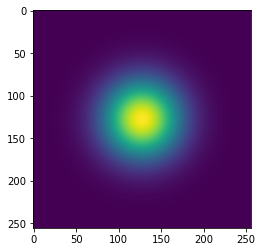

In [ ]:
# Tests
gw = gaussian_kernel_2d((256,256), sigma_scale=1/8)
test_eq(gw.max(), 1)
plt.imshow(gw);

Calculation of epistemic and aleatoric uncertainy

In [ ]:
#export 
# adapted from https://github.com/ykwon0407/UQ_BNN/blob/master/retina/utils.py
@torch.jit.script
def epistemic_uncertainty(x: torch.Tensor):
    return torch.mean(x**2, dim=0) - torch.mean(x, dim=0)**2

@torch.jit.script
def aleatoric_uncertainty(x: torch.Tensor):
    return torch.mean(x * (1 - x), dim=0)

@torch.jit.script
def uncertainty(x: torch.Tensor):
    # Add uncertainties
    uncertainty = epistemic_uncertainty(x) + aleatoric_uncertainty(x)
    # Scale to 1 max overall
    uncertainty /= 0.25
    return uncertainty

## Tiling

Functions and classes for tiling (slicing) images

In [ ]:
#export
@torch.jit.export
def get_in_slices_1d(center:torch.Tensor, len_x:int, len_tile:int) ->torch.Tensor: 
    start = (len_tile/2-center).clip(0).to(torch.int64)
    stop = torch.tensor(len_tile).clip(max=(len_x-center+len_tile/2).to(torch.int64))
    return torch.stack((start, stop))
    
@torch.jit.export
def get_out_slices_1d(center:torch.Tensor, len_x:int, len_tile:int) ->torch.Tensor: 
    start = (center - (len_tile/2)).clip(0, len_x).to(torch.int64)
    stop = (center + (len_tile/2)).clip(max=len_x).to(torch.int64)
    return torch.stack((start, stop))

In [ ]:
#export
class TileModule(torch.nn.Module):
    "Class for tiling data."
    def __init__(self, 
                 tile_shape = (512, 512), 
                 scale:float = 1.,
                 border_padding_factor:float = 0.25,
                 max_tile_shift:float = 0.5):
        
        super(TileModule, self).__init__()
        self.tile_shape = tile_shape
        self.scale = scale
        self.border_padding_factor = border_padding_factor
        self.max_tile_shift = max_tile_shift
        
        grid_range = [torch.linspace(-self.scale, self.scale, steps=d) for d in tile_shape] 
        self.deformationField = torch.meshgrid(*grid_range, indexing='ij')
        
        
    @torch.jit.export
    def get_centers_1d(self, len_x:int, len_tile:int) ->torch.Tensor:
        len_padding = float(len_tile*self.border_padding_factor)
        start_point = len_tile/2 - len_padding
        end_point = len_x - start_point
        #end_point = max(len_x - start_point, start_point)
        n_points = int((len_x+2*len_padding)//(len_tile*self.max_tile_shift))+1
        return torch.linspace(start_point, end_point, n_points, dtype=torch.int64)
    
    @torch.jit.export
    def get_center_combinations(self, shape:List[int]) ->torch.Tensor:
        c_list = [self.get_centers_1d(shape[i], self.tile_shape[i]) for i in range(2)]
        center_combinations = torch.meshgrid(c_list[0],c_list[1], indexing='ij')
        return torch.stack(center_combinations).permute([2, 1, 0]).reshape(-1,2)
    
    
    @torch.jit.export
    def get_slices_and_centers(self, shape:List[int]) -> Tuple[List[torch.Tensor], List[torch.Tensor], torch.Tensor]:
        shape = [int(shape[i]/self.scale) for i in range(2)]
        center_combinations =  self.get_center_combinations(shape)
        in_slices = [get_in_slices_1d(center_combinations[:,i], shape[i], self.tile_shape[i]) for i in range(2)]    
        out_slices = [get_out_slices_1d(center_combinations[:,i], shape[i], self.tile_shape[i]) for i in range(2)] 
        scaled_centers = (center_combinations*self.scale).type(torch.int64)
        
        return in_slices, out_slices, scaled_centers            
    
    @torch.jit.export
    def forward(self, x, center:torch.Tensor) ->torch.Tensor:
        "Apply deformation field to image using interpolation"

        # Align grid to relative position and scale
        grids = []
        for i in range(2):
            s = x.shape[i]
            scale_ratio = self.tile_shape[i]/s
            relative_center = (center[i]-s/2)/(s/2)
            coords = (self.deformationField[i]*scale_ratio)+relative_center
            grids.append(coords.to(x))
        
        # grid with shape (N, H, W, 2)
        vgrid = torch.stack(grids[::-1], dim=-1).to(x).unsqueeze_(0)
        
        # input with shape (N, C, H, W)
        x = x.permute(2,0,1).unsqueeze_(0)
        
        # Remap
        x = torch.nn.functional.grid_sample(x, vgrid, mode='bilinear', padding_mode='reflection', align_corners=True)
        
        return x

In [ ]:
#hide
# Generate an initial random image and mask with two circles
np.random.seed(0)
x, y = np.indices((540, 540))
x1, y1, x2, y2 = 180, 180, 41*7, 52*7
r1, r2 = 10*7.20, 20*7
mask_circle1 = (x - x1) ** 2 + (y - y1) ** 2 < r1 ** 2
mask_circle2 = (x - x2) ** 2 + (y - y2) ** 2 < r2 ** 2
mask = np.logical_or(mask_circle1, mask_circle2).astype(int)
mask[:10,:] = 1
mask[-10:,:] = 1
mask[:,:10] = 1
mask[:,-10:] = 1
image = np.random.rand(*mask.shape)+mask*2.
image /= image.max()

In [ ]:
# Tests: Output == Input
ts = 540
os = ts/2

t = TileModule(tile_shape=(ts, ts))
inp = torch.from_numpy(image).float().unsqueeze_(-1)
out = t(inp, (os,os))[0,0]
test_close(out,image, eps=1e-04)

In [ ]:
# (Visual) tests: Different arg combinations
TS = [256, 512, 1024]
SCALES = [0.5, 1., 2.]
SHIFTS = [0.5, 0.9, 1.]
BPFACTORS = [0.25, 0.1, 0.]
inp = torch.from_numpy(image).float().unsqueeze_(-1)

for ts in TS:
    for scale in SCALES:
        for max_tile_shift in SHIFTS:
            for border_padding_factor in BPFACTORS:
                t = TileModule(tile_shape=(ts, ts), scale=scale, max_tile_shift=max_tile_shift, border_padding_factor=border_padding_factor)
                out = torch.zeros(*[int(x/t.scale) for x in inp.shape[:2]]).unsqueeze_(-1)
                in_slices, out_slices, center_points = t.get_slices_and_centers(inp.shape)
                assert len(center_points)!=0
                for i, cp in enumerate(center_points):
                    ix0, ix1, iy0, iy1 = in_slices[0][0][i], in_slices[0][1][i], in_slices[1][0][i], in_slices[1][1][i]
                    ox0, ox1, oy0, oy1 = out_slices[0][0][i], out_slices[0][1][i], out_slices[1][0][i], out_slices[1][1][i]
                    assert (ix1-ix0) == (ox1-ox0), 'Input/Output slices do not match'
                    assert (iy1-iy0) == (oy1-oy0), 'Input/Output slices do not match'
                    tile = t(inp, cp)
                    out[ox0:ox1, oy0:oy1, 0] += tile[0 ,0, ix0:ix1, iy0:iy1]
                    #plt.imshow(out)
                    #plt.show()

In [ ]:
# Test onnx export
if torch.__version__.split(".") >= ["1", "12", "0"]:
    print(torch.__version__)
    t_scripted = torch.jit.script(t)
    ost = torch.tensor(os)
    path = Path('TileModule.onnx')
    _ = torch.onnx.export(t_scripted, (inp, torch.tensor([ost, ost])), path, verbose=True, opset_version=16)
    path.unlink()

## Inference Ensemble
Scripable module for inference with multiple models

In [ ]:
#export
class InferenceEnsemble(torch.nn.Module):
    'Class for model ensemble inference'
    def __init__(self, 
                 models:List[torch.nn.Module],
                 num_classes:int, 
                 in_channels:int,
                 channel_means:List[float],
                 channel_stds:List[float],
                 tile_shape:Tuple[int,int]=(512,512), 
                 use_gaussian: bool = True, 
                 gaussian_kernel_sigma_scale:float = 1./8,
                 use_tta:bool=True,
                 border_padding_factor:float = 0.25,
                 max_tile_shift:float = 0.9,
                 scale:float = 1.,
                 device:str='cpu'): 
        
        super().__init__()     
        self.num_classes = num_classes
        self.use_tta = use_tta
        self.use_gaussian = use_gaussian
        self.gaussian_kernel_sigma_scale = gaussian_kernel_sigma_scale
        self.tile_shape = tile_shape
        self.norm = Normalize(channel_means, channel_stds)
        
        dummy_input = torch.rand(1, in_channels, *self.tile_shape).to(device)
        self.models = torch.nn.ModuleList([torch.jit.trace(m.to(device).eval(), dummy_input) for m in models])
        
        self.tiler = torch.jit.script(TileModule(tile_shape=tile_shape, 
                                                 scale=scale, 
                                                 border_padding_factor=border_padding_factor, 
                                                 max_tile_shift=max_tile_shift))
        
        mw = gaussian_kernel_2d(tile_shape, gaussian_kernel_sigma_scale) if use_gaussian else torch.ones(tile_shape[0], tile_shape[1])
        self.register_buffer('mw', mw)
        
        tfms = [tta.HorizontalFlip(),tta.VerticalFlip()] if self.use_tta else []
        self.tta_tfms = tta.Compose(tfms)
            
    def forward(self, x):
        
        # Extract image shape (assuming HWC)
        sh = x.shape[:-1]
        # Workaround for sh_scaled = [int(s/self.tiler.scale) for s in img_shape]
        sh_scaled = (torch.tensor(sh)/self.tiler.scale).to(torch.int64)
        sh_scaled = [int(t.item()) for t in sh_scaled]
        
        # Create zero arrays (only on CPU RAM to avoid GPU memory overflow on large images)
        # softmax = torch.zeros((sh_scaled[0], sh_scaled[1], self.num_classes), dtype=torch.float32, device=x.device)
        softmax = torch.zeros((self.num_classes, sh_scaled[0], sh_scaled[1]), dtype=torch.float32, device=x.device)
        merge_map = torch.zeros((sh_scaled[0], sh_scaled[1]), dtype=torch.float32, device=x.device)
        stdeviation = torch.zeros((sh_scaled[0], sh_scaled[1]), dtype=torch.float32, device=x.device)
        
        # Get slices for tiling
        in_slices, out_slices, center_points = self.tiler.get_slices_and_centers(sh)
        
        #
        self.mw.to(x)
        
        # Loop over tiles
        for i, cp in enumerate(center_points):
            
            tile = self.tiler(x, cp)
            
            # Normalize
            tile = self.norm(tile)
        
            smxs = []   
            # Loop over tt-augmentations
            for t in self.tta_tfms.items: 
                aug_tile = t.augment(tile)

                # Loop over models
                for model in self.models:
                    logits = model(aug_tile)
                    logits = t.deaugment(logits)
                    smxs.append(F.softmax(logits, dim=1))

            smxs = torch.stack(smxs)
                        
            ix0, ix1, iy0, iy1 = in_slices[0][0][i], in_slices[0][1][i], in_slices[1][0][i], in_slices[1][1][i]
            ox0, ox1, oy0, oy1 = out_slices[0][0][i], out_slices[0][1][i], out_slices[1][0][i], out_slices[1][1][i]
            
            # Apply weigthing
            batch_smx = torch.mean(smxs, dim=0)*self.mw.view(1,1,self.mw.shape[0],self.mw.shape[1])
            #softmax[ox0:ox1, oy0:oy1] += batch_smx.permute(0,2,3,1)[0][ix0:ix1, iy0:iy1].to(softmax)  
            softmax[..., ox0:ox1, oy0:oy1] += batch_smx[0, ..., ix0:ix1, iy0:iy1].to(softmax)  
            merge_map[ox0:ox1, oy0:oy1] += self.mw[ix0:ix1, iy0:iy1].to(merge_map)
            
            # Encertainty_estimates
            batch_std = torch.mean(uncertainty(smxs), dim=1)*self.mw.view(1,self.mw.shape[0],self.mw.shape[1])
            stdeviation[ox0:ox1, oy0:oy1] += batch_std[0][ix0:ix1, iy0:iy1].to(stdeviation)
            

        # Normalize weighting
        softmax /= torch.unsqueeze(merge_map, 0)
        stdeviation /= merge_map
        
        # Rescale results
        if self.tiler.scale!=1.:
            softmax = F.interpolate(softmax.unsqueeze_(0), scale_factor=self.tiler.scale, mode="bilinear", align_corners=True)[0]
            stdeviation = stdeviation.view(1, 1, stdeviation.shape[0], stdeviation.shape[1])
            stdeviation = F.interpolate(stdeviation, scale_factor=self.tiler.scale, mode="bilinear", align_corners=True)[0][0]
        
        argmax = torch.argmax(softmax, dim=0).to(torch.uint8)

        return argmax, softmax, stdeviation    

In [ ]:
# Dummy class for testing
class DummyModule(torch.nn.Module):
    'Dummy Module for testing'
    def __init__(self, num_classes=2):
        super().__init__()
        self.num_classes = num_classes
    
    def forward(self, x):
        return x[:,:1].repeat(1, self.num_classes, 1,1)

In [ ]:
# Testing with different params
CHANNELS = [1,3]
NUM_CLASSES = [2, 5]
SCALES = [0.5, 1., 4.]
IMG_SHAPES = [512]#[256, 512, 1024]

for ch in CHANNELS:
    channel_means = [0.]*ch
    channel_stds = [1.]*ch
    for num_classes in NUM_CLASSES:
        models = [DummyModule(num_classes=num_classes) for _ in range(2)]
        for sx in IMG_SHAPES:
            for sy in IMG_SHAPES:
                inp = torch.rand(sx,sy, ch)
                for scale in SCALES:
                    ensemble = InferenceEnsemble(models, 
                                                 num_classes=num_classes, 
                                                 in_channels=3, 
                                                 channel_means=channel_means,
                                                 channel_stds=channel_stds, 
                                                 scale=scale)
                    ensemble = torch.jit.script(ensemble)
                    outs = ensemble(inp)
                    test_eq(outs[0].shape, (sx, sy))
                    test_eq(outs[1].shape, (num_classes, sx, sy))
                    test_eq(outs[2].shape, (sx, sy))

In [ ]:
# Test torchscript export
path_pt = Path('ensemble.pt')
scripted_ensemble = torch.jit.script(ensemble)
scripted_ensemble.save(path_pt)
_ = torch.jit.load(path_pt)
path_pt.unlink()

In [ ]:
# Test onnx export
if torch.__version__.split(".") >= ["1", "12", "0"]:
    print(torch.__version__)
    input_names=["inp"]
    output_names=["argmax", "softmax", "stdeviation"]
    dynamic_axes = {"inp": [0, 1], "argmax": [0, 1], "softmax": [0, 1, 2], "stdeviation": [0, 1]}
    path_onnx = Path('ensemble.onnx')
    torch.onnx.export(scripted_ensemble, inp, f=path_onnx, verbose=True, opset_version=16, 
                      input_names=input_names, output_names=output_names, dynamic_axes=dynamic_axes)
    
    #import onnxruntime
    #ort_session = onnxruntime.InferenceSession(path_onnx.as_posix())

# Export -

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_config.ipynb.
Converted 01_models.ipynb.
Converted 02_data.ipynb.
Converted 03_learner.ipynb.
Converted 04_inference.ipynb.
Converted 05_losses.ipynb.
Converted 06_utils.ipynb.
Converted 07_tta.ipynb.
Converted 08_gui.ipynb.
Converted 09_gt.ipynb.
Converted add_information.ipynb.
Converted index.ipynb.
Converted model_library.ipynb.
Converted tutorial.ipynb.
Converted tutorial_gt.ipynb.
Converted tutorial_pred.ipynb.
Converted tutorial_train.ipynb.
